In [305]:
a = 0.3
b = 0.5
import numpy as np

def lambda1(beta1, beta2):
    nom = (b-a)*(beta1-beta2)
    denom = (b-a-1)*beta2-(b-a)*beta1
    
    return nom/denom

def lambda2(beta1, beta2):
    nom = (b-a-1)*(beta1-beta2)
    denom = (b-a-1)*beta2-(b-a)*beta1
    
    return nom/denom

def effbeta(beta1, beta2):
    lam1 = lambda1(beta1, beta2)
    lam2 = lambda2(beta1, beta2)
    
    beta = beta1*(lam1+1)*(1+a-b)+beta2*(b-a)*(lam2+1)
    #beta = np.cos(beta1) + np.sin(beta2)
    return beta

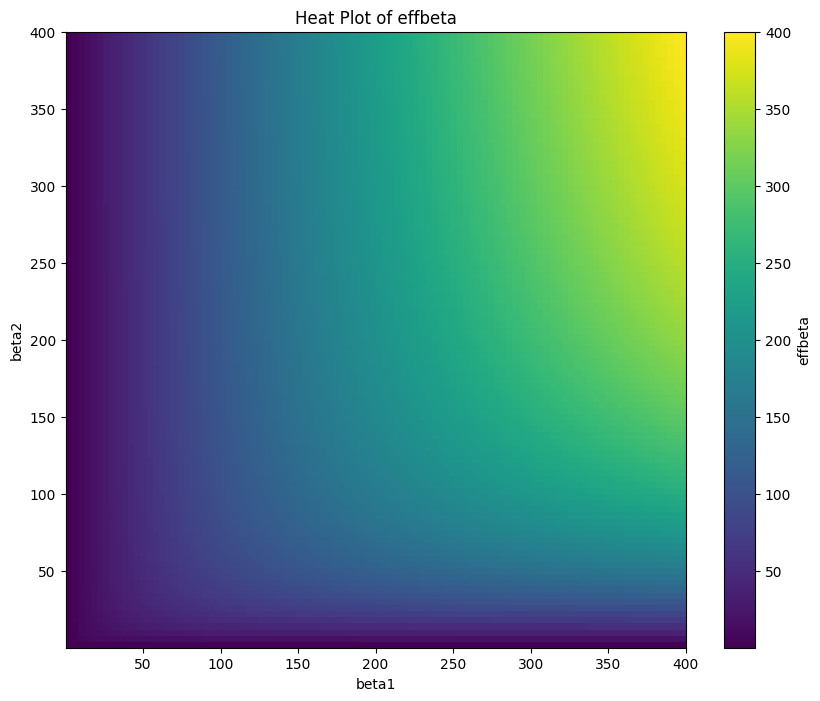

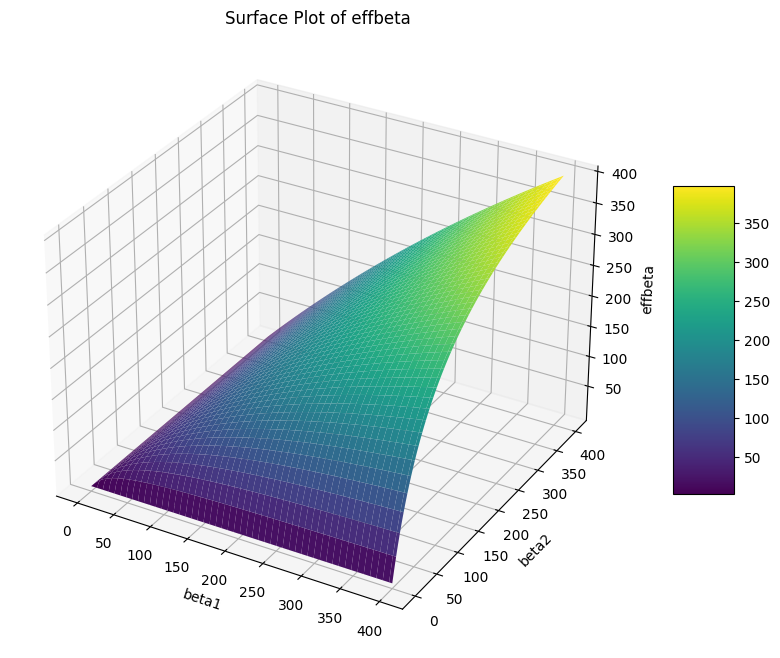

In [306]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for the range of beta1 and beta2 values
beta1_range = np.linspace(0.05, 400, 100)
beta2_range = np.linspace(0.05, 400, 100)
beta1, beta2 = np.meshgrid(beta1_range, beta2_range)

# Compute effbeta for each combination of beta1 and beta2
eff_beta_values = effbeta(beta1, beta2)

# Create a heat plot
plt.figure(figsize=(10, 8))
plt.imshow(eff_beta_values, extent=(0.05, 400, 0.05, 400), origin='lower', aspect='auto')
plt.colorbar(label='effbeta')
plt.xlabel('beta1')
plt.ylabel('beta2')
plt.title('Heat Plot of effbeta')
plt.show()

# Create a surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(beta1, beta2, eff_beta_values, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('effbeta')
ax.set_title('Surface Plot of effbeta')
plt.show()

In [307]:
import torch
import torch.nn as nn
import itertools

class ClassicalSurrogate(nn.Module):
    def __init__(self, z_function, omega_spectrum):
        super(ClassicalSurrogate, self).__init__()
        self.omegas = omega_spectrum
        
        self.alpha = nn.Parameter(torch.empty(self.omegas.size(0), dtype=torch.float64))
        self.beta = nn.Parameter(torch.empty(self.omegas.size(0), dtype=torch.float64))
        nn.init.normal_(self.alpha)
        nn.init.normal_(self.beta)
        self.z_function = z_function

    def forward(self, x):
        z_x = self.z_function(x)
        
        # Compute dot product
        dot_products = torch.mm(z_x, self.omegas.t())
        
        # Compute cosine and sine values
        cos_values = torch.cos(dot_products)
        sin_values = torch.sin(dot_products)
        
        # Weighted sum of cosine and sine values for each sample
        outputs = torch.sum(self.alpha.squeeze() * cos_values + self.beta.squeeze() * sin_values, dim=1)
        return outputs.unsqueeze(1)
    
    def fit_fourier_coefficients(self, X, Y):
        with torch.no_grad():
            # Compute the feature vectors for the dataset
            z_x = self.z_function(X)
            dot_products = torch.mm(z_x, self.omegas.t())
            cos_values = torch.cos(dot_products)
            sin_values = torch.sin(dot_products)

            # Stack features and add a column for the bias term
            features = torch.cat([cos_values, sin_values], dim=1)

            # Solve the least squares problem A*c = b
            coefficients = torch.linalg.lstsq(features, Y, driver='gelsd').solution.squeeze()

            # Update the parameters with the new coefficients
            self.alpha.data = coefficients[:self.omegas.size(0)]
            self.beta.data = coefficients[self.omegas.size(0):]

# Example usage:
def id_z(x):
    # For demonstration, we're returning x. Replace this with any required transformation.
    return x

# Assuming z(x) is a 3-dimensional vector, and each component can take values [1.0, 2.0] or [2.0, 3.0] or [1.0, 3.0]
L = 32
omega_spectrum = [list(range(-L, L+1)), list(range(-L, L+1))]
#omega_spectrum = list(range(-L, L+1))
all_combinations = list(itertools.product(*omega_spectrum))
all_combinations = torch.tensor(all_combinations, dtype=torch.float64)
print(all_combinations.shape)
model = ClassicalSurrogate(id_z, all_combinations)

# Example forward pass:
x = torch.tensor([[1.0, 2], [3.0, 4]], dtype=torch.float64)
output = model(x)
print(output)
print(output.shape)

torch.Size([4225, 2])
tensor([[ 18.8061],
        [-45.7005]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
torch.Size([2, 1])


In [308]:
y = model(x)
print(x)
print(y)

tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)
tensor([[ 18.8061],
        [-45.7005]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)


In [309]:
print(0.0451*0.7568)

0.034131680000000005


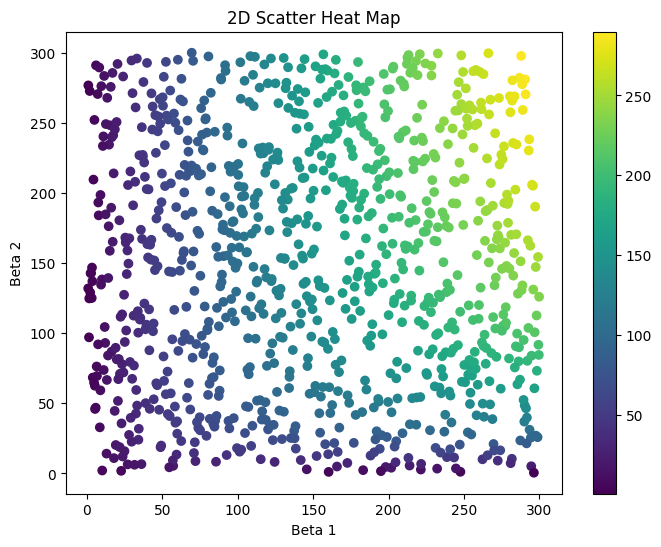

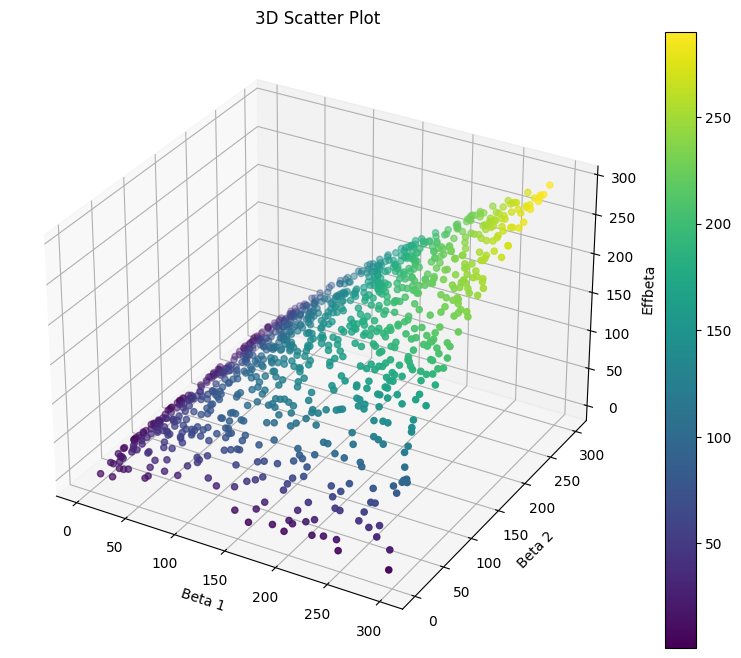

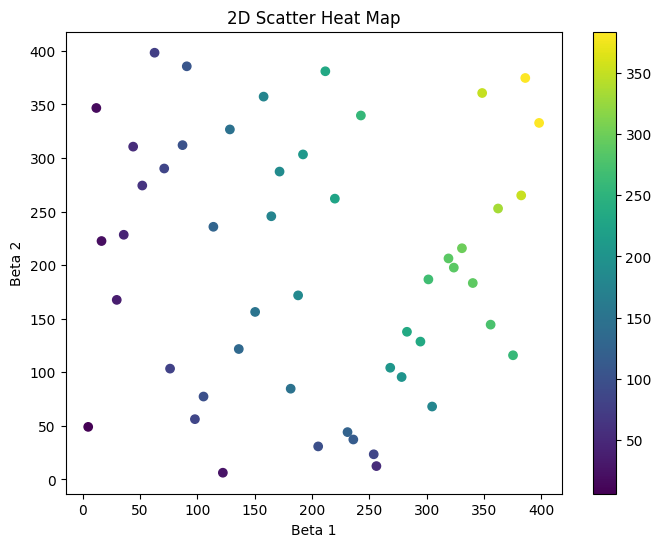

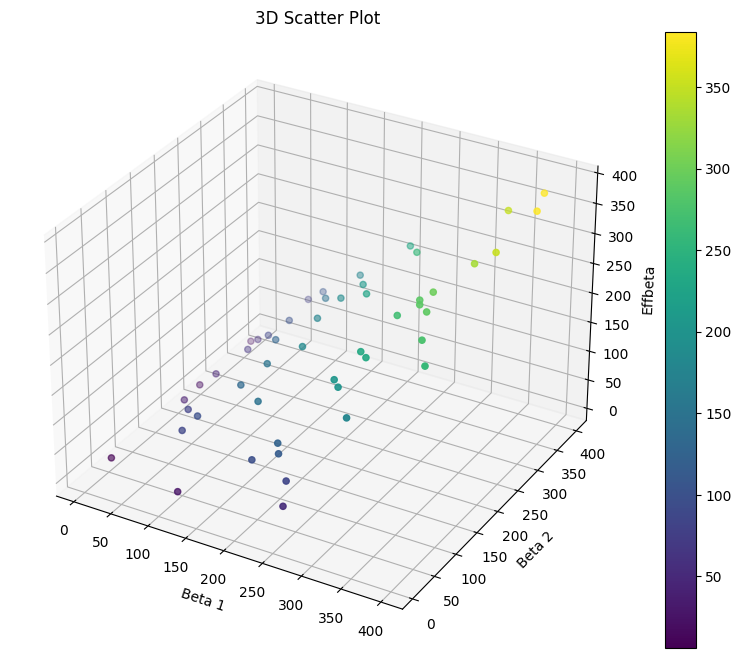

In [310]:
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate samples using Latin Hypercube Sampling
n_train = 1000  # Number of samples
n_valid = 50
lower_bounds = np.array([0.5, 0.5])
upper_bounds = np.array([300, 300])
X_train = lhs(2, samples=n_train)
X_train = lower_bounds + (upper_bounds - lower_bounds) * X_train

lower_bounds = np.array([0.05, 0.05])
upper_bounds = np.array([400, 400])
X_valid = lhs(2, samples=n_valid)
X_valid = lower_bounds + (upper_bounds - lower_bounds) * X_valid

# Evaluate the function at each sample point and add Gaussian noise
Y_train = np.array([effbeta(sample[0], sample[1]) for sample in X_train])
sigma = 0.001
noise = np.random.normal(0, sigma, Y_train.shape)
Y_train = Y_train + noise

Y_valid = np.array([effbeta(sample[0], sample[1]) for sample in X_valid])

# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('Beta 1')
plt.ylabel('Beta 2')
plt.title('2D Scatter Heat Map')
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_train[:, 0], X_train[:, 1], Y_train, c=Y_train, cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('Beta 1')
ax.set_ylabel('Beta 2')
ax.set_zlabel('Effbeta')
plt.title('3D Scatter Plot')
plt.show()

# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_valid[:, 0], X_valid[:, 1], c=Y_valid, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('Beta 1')
plt.ylabel('Beta 2')
plt.title('2D Scatter Heat Map')
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_valid[:, 0], X_valid[:, 1], Y_valid, c=Y_valid, cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('Beta 1')
ax.set_ylabel('Beta 2')
ax.set_zlabel('Effbeta')
plt.title('3D Scatter Plot')
plt.show()


In [311]:
import torch
import logging
from torch.optim import Adam
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset

# Data
batch_size=25
X_train = torch.tensor(X_train, dtype=torch.float64)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).unsqueeze(1)
Y_valid = torch.tensor(Y_valid, dtype=torch.float64).unsqueeze(1)

data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=False)

# Trainer
lr = 0.1
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
loss_fn = torch.nn.MSELoss()
logger = logging.getLogger("train_function")
logger.setLevel(level=logging.INFO)
num_epochs = 200
trainer = SupervisedTrainer(optimizer=optimizer,
                            loss_fn=loss_fn,
                            num_epochs=num_epochs,
                            logger=logger)

In [312]:
# Train
#trainer.train(model, train_data=loader_train, valid_data=loader_valid)
from torchmetrics.regression import MeanAbsolutePercentageError
model.fit_fourier_coefficients(X_train, Y_train)
predicted_train = model(X_train)
predicted_valid = model(X_valid)

metric = MeanAbsolutePercentageError()
loss_train = metric(predicted_train, Y_train)
loss_valid = metric(predicted_valid, Y_valid)
print("train loss: ", loss_train)
print("valid_loss: ", loss_valid)

train loss:  tensor(1.3312e-14, grad_fn=<SqueezeBackward0>)
valid_loss:  tensor(0.9744, grad_fn=<SqueezeBackward0>)


model = ClassicalSurrogate(id_z, all_combinations)

print(model.omegas)
alphas = np.zeros(9)
betas = np.zeros(9)
alphas[8] = 1.0
betas[5] = 1
#model.alpha.data = torch.tensor(alphas)
#model.beta.data = torch.tensor(betas)

grid_size = 10
x = np.linspace(1, 2, grid_size)
y = np.linspace(1, 2, grid_size)
X_train = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
Y_train = np.sin(X_train[:, 1])

X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).unsqueeze(1)

predicted = model(X_train)
loss = loss_fn(predicted, Y_train)
print("Before fitting: ", loss)

model.fit_fourier_coefficients(X_train, Y_train)

predicted = model(X_train)
loss = loss_fn(predicted, Y_train)
print("After fitting: ", loss)

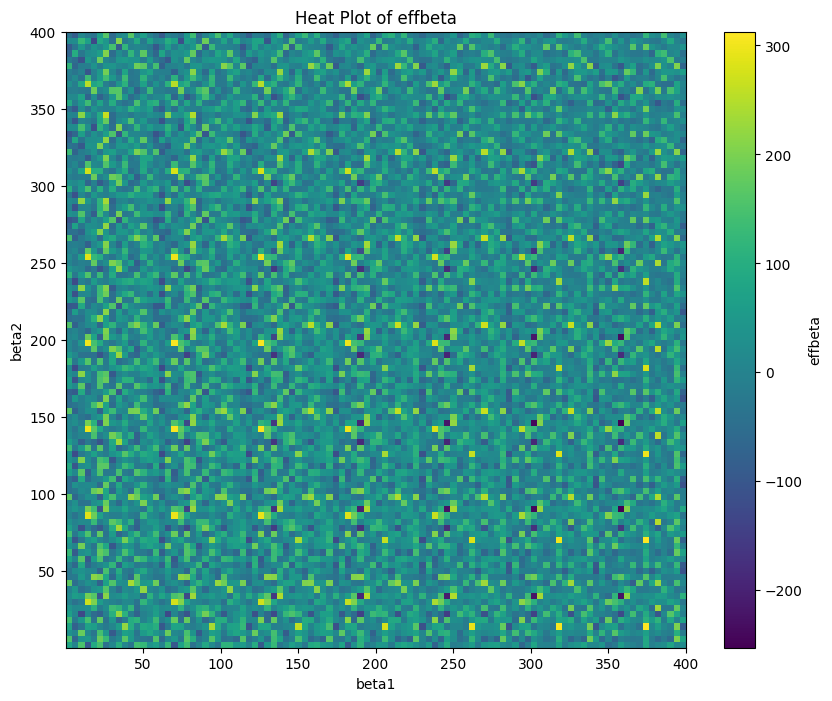

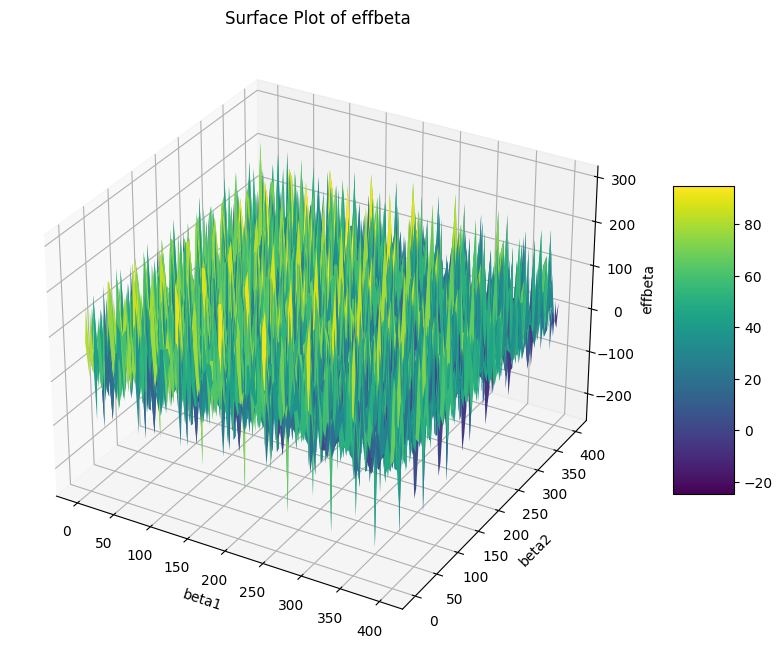

In [313]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for the range of beta1 and beta2 values
beta1_range = np.linspace(0.05, 400, 100)
beta2_range = np.linspace(0.05, 400, 100)
beta1, beta2 = np.meshgrid(beta1_range, beta2_range)
betas = np.vstack([beta1.ravel(), beta2.ravel()]).T
betas_tensor = torch.tensor(betas, dtype=torch.float64)

# Compute effbeta for each combination of beta1 and beta2
with torch.no_grad():
    predicted = model(betas_tensor)
    
predicted_reshaped = predicted.reshape(beta1.shape)

# Create a heat plot
plt.figure(figsize=(10, 8))
plt.imshow(predicted_reshaped, extent=(0.05, 400, 0.05, 400), origin='lower', aspect='auto')
plt.colorbar(label='effbeta')
plt.xlabel('beta1')
plt.ylabel('beta2')
plt.title('Heat Plot of effbeta')
plt.show()

# Create a surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(beta1, beta2, predicted_reshaped, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('effbeta')
ax.set_title('Surface Plot of effbeta')
plt.show()